# ALS & BPR

In [363]:
# !pip install implicit

In [364]:
import numpy as np
import pandas as pd
import time
from scipy.sparse import csr_matrix

from typing import List, Set

In [365]:
# for reproducibility
SEED = 2025
np.random.seed(SEED)

## Load MovieLens data

In [366]:
ratings = pd.read_csv(
    "/Users/codexplore/Developer/repos/recommender-system/data/movielens/ml-100k/u.data",
    sep="\t",
    names=["user", "item", "rating", "timestamp"]
)

# implicit feedback: rating >= 4
ratings["implicit"] = (ratings["rating"] >= 4).astype(int)
# implicit feedback: rating >= 4 
df = ratings[ratings["implicit"] == 1].copy()



In [367]:
# Encode to 0-index
user2id = {uid: i for i, uid in enumerate(df.user.unique())}
item2id = {iid: i for i, iid in enumerate(df.item.unique())}
df["uid"] = df["user"].map(user2id)
df["iid"] = df["item"].map(item2id)

n_users = df["uid"].nunique()
n_items = df["iid"].nunique()
print(n_users, n_items)

942 1447


In [368]:
print(df[df.user == 300])

       user  item  rating  timestamp  implicit  uid   iid
3641    300   948       4  875650018         1  297   685
3899    300   243       4  875650068         1  297   705
6119    300   322       4  875650018         1  297    27
14293   300   872       5  875650068         1  297  1050
14704   300   257       4  875650267         1  297   390
21143   300   456       4  875650267         1  297  1140
28987   300   876       5  875650105         1  297   652
38383   300   288       4  875649995         1  297   201
38880   300   300       4  875649995         1  297   454
40146   300   409       4  875650329         1  297   531
44691   300   881       5  875650105         1  297   913
46844   300   833       4  875650329         1  297   725
59243   300  1094       5  875650298         1  297   966
88105   300  1012       4  875650329         1  297   419


## Train/Test split (Leave-One-Out, temporal)

In [369]:
df_train = []
df_val = []
df_test = []

for uid, user_data in df.groupby("uid"):
    user_data = user_data.sort_values("timestamp")
    if len(user_data) < 3:
        continue
    df_train.append(user_data.iloc[:-2]) # all but last two interactions
    df_val.append(user_data.iloc[-2:-1]) # second last interaction
    df_test.append(user_data.iloc[-1:]) # last interaction

df_train = pd.concat(df_train)
df_val = pd.concat(df_val)
df_test = pd.concat(df_test)

R_train = csr_matrix(
    (
       df_train["implicit"].values,
       (df_train["uid"].values, df_train["iid"].values)
    ),
    shape=(n_users, n_items)
)

val_items = df_val.groupby("uid")["iid"].apply(set).to_dict()
test_items = df_test.groupby("uid")["iid"].apply(set).to_dict()

## Evaluation Metrics

In [370]:
# ============================================================
# Evaluate 
# ============================================================
def recall_at_k(rec_items: List, true_items: Set, K):
    n_hit = len(set(rec_items[:K]) & true_items)
    n_true = len(true_items)
    if n_true == 0:
        return 0.0
    return n_hit / n_true

def hr_at_k(rec_items: List, true_items: Set, K):
    "Hit Rate at k"
    n_hit = len(set(rec_items[:K]) & true_items)
    return 1.0 if n_hit > 0 else 0.0

def ndcg_at_k(rec_items: List, true_items: Set, K):
    dcg = 0.0
    for i, item in enumerate(rec_items[:K]):
        if item in true_items:
            dcg += 1.0 / np.log2(i + 2)  # i + 2 because i starts from 0
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(true_items), K)))
    if idcg == 0:
        return 0.0
    return dcg / idcg

def map_at_k(rec_items: List, true_items: Set, K):
    """MAP@K (Mean Average Precision at K) measures the quality of ranked recommendations by rewarding relevant items appearing earlier in the list.
    
    AP = (1 / position) if hit else 0

    # Hit at position 1 → AP = 1.0
    # Hit at position 5 → AP = 0.2
    # No hit           → AP = 0.0
    """
    hit_count = 0
    precision_score = 0.0
    for i, item in enumerate(rec_items[:K]):
        if item in true_items:
            hit_count += 1
            precision_score += hit_count / (i + 1) # Precision at this position
            #                      ↑ cumulative hits
            #                                 ↑ position (1-indexed)
    if hit_count == 0:
        return 0.0
    return precision_score / min(len(true_items), K) if true_items else 0.0

## Baseline 

In [371]:
from abc import ABC, abstractmethod

class BaseRecommender(ABC):
    """Abstract base class for all recommenders."""
    
    @abstractmethod
    def fit(self, R_train):
        pass
    
    @abstractmethod
    def recommend(self, user_id, K=10):
        """Return list of K recommended item IDs."""
        pass

In [372]:
# ============================================================
# Baseline Recommenders
# ============================================================
class RandomRecommender(BaseRecommender):
    """Random baseline."""
    
    def __init__(self, n_items, seed=42):
        self.n_items = n_items
        self.rng = np.random.default_rng(seed)
        self.R_train = None
    
    def fit(self, R_train):
        self.R_train = R_train
        return self
    
    def recommend(self, user_id, K=10):
        seen = set(self.R_train[user_id].indices)
        candidates = [i for i in range(self.n_items) if i not in seen]
        return self.rng.choice(candidates, size=min(K, len(candidates)), replace=False)


class PopularityRecommender(BaseRecommender):
    """Popularity baseline."""
    
    def __init__(self):
        self.popular_items = None
        self.R_train = None
    
    def fit(self, R_train):
        self.R_train = R_train
        item_counts = np.array(R_train.sum(axis=0)).flatten()
        self.popular_items = np.argsort(item_counts)[::-1]
        return self
    
    def recommend(self, user_id, K=10):
        seen = set(self.R_train[user_id].indices)
        recs = [item for item in self.popular_items if item not in seen][:K]
        return np.array(recs)

# ============================================================
# Evaluation Function for Baselines
# ============================================================
def evaluate(model: BaseRecommender, test_items: dict, K:int=10):
    """
    Evaluate any recommender that follows BaseRecommender interface.
    """
    recalls, hit_rates, ndcgs, maps = [], [], [], []
    
    for uid, true_items in test_items.items():
        rec_items = model.recommend(uid, K) # Ordered list
        
        recalls.append(recall_at_k(rec_items, true_items, K))
        hit_rates.append(hr_at_k(rec_items, true_items, K))
        ndcgs.append(ndcg_at_k(rec_items, true_items, K))
        maps.append(map_at_k(rec_items, true_items, K))
        
       
    return {
        "Recall@K": np.mean(recalls),
        "HitRate@K": np.mean(hit_rates),
        "NDCG@K": np.mean(ndcgs),
        "MAP@K": np.mean(maps)
    }





# ============================================================
# Train and Evaluate Baselines
# ============================================================

# Initialize
random_rec = RandomRecommender(n_items=n_items, seed=SEED)
popular_rec = PopularityRecommender()

# Fit on training data
random_rec.fit(R_train)
popular_rec.fit(R_train)

# Evaluate
random_results = evaluate(random_rec, test_items, K=10)
popular_results = evaluate(popular_rec, test_items, K=10)

# ============================================================
# Compare All Models
# ============================================================

print("=" * 50)
print("Model Comparison (K=10)")
print("=" * 50)

results_df = pd.DataFrame({
    "Random": random_results,
    "Popularity": popular_results,
}).T

print(results_df.round(4))


Model Comparison (K=10)
            Recall@K  HitRate@K  NDCG@K   MAP@K
Random        0.0096     0.0096  0.0036  0.0019
Popularity    0.0817     0.0817  0.0399  0.0273


## ALS

In [373]:
from implicit.als import AlternatingLeastSquares

In [374]:
# ============================================================
# Train ALS
# ============================================================

als = AlternatingLeastSquares(
    factors=32,
    regularization=0.1,
    iterations=15,
    random_state=SEED
)

start = time.time()
als.fit(R_train)
als_time = time.time() - start

print(f"ALS training time: {als_time:.2f}s")

100%|██████████| 15/15 [00:00<00:00, 324.84it/s]

ALS training time: 0.05s


In [375]:
def retrieve_candidates(als_model, R_train, uid, C=100):
    # retrieves a broad set of candidates (C=100) for a single user `uid`
    rec_items, rec_scores = als_model.recommend(
        userid=uid,
        #  user_items: tells the model which items the user has already interacted with during training
        user_items=R_train[uid],
        N=C,
        # Result: Only recommends NEW items the user hasn't seen
        filter_already_liked_items=True
    )
    return rec_items, rec_scores

In [376]:
def evaluate_model(als_model, R_train, true_items_dict, K=10):
    recalls = []
    hrs = []
    ndcgs = []
    maps = []

    for uid, true_items in true_items_dict.items():
        rec_items, _ = retrieve_candidates(als_model, R_train, uid, C=K)

        recalls.append(recall_at_k(rec_items, true_items, K))
        hrs.append(hr_at_k(rec_items, true_items, K))
        ndcgs.append(ndcg_at_k(rec_items, true_items, K))
        maps.append(map_at_k(rec_items, true_items, K))

    return {
        f"Recall@{K}": np.mean(recalls),
        f"HitRate@{K}": np.mean(hrs),
        f"NDCG@{K}": np.mean(ndcgs),
        f"MAP@{K}": np.mean(maps)
    }

In [377]:
evaluate_model(als, R_train, val_items, K=10)

{'Recall@10': 0.15180467091295116,
 'HitRate@10': 0.15180467091295116,
 'NDCG@10': 0.07642985295150712,
 'MAP@10': 0.05376015232703132}

### Hyper-param tuning

In [378]:
# ============================================================
# Hyperparameter tuning (optional)
# ============================================================
import itertools

K = 10
# Define grid
param_grid = {
    'factors': [32, 64, 128],               # Latent Dimensions
    'regularization': [0.001, 0.01, 0.1],   # Regularization
    'iterations': [15, 20, 30],
    'alpha': [1, 10, 40]                    # Confidence weight
}

best_score = 0
best_params = None

# Grid search
for factors, reg, iters, alpha in itertools.product(
    param_grid['factors'],
    param_grid['regularization'],
    param_grid['iterations'],
    param_grid['alpha']
):
    model = AlternatingLeastSquares(
        factors=factors,
        regularization=reg,
        iterations=iters,
        random_state=SEED
    )
    
    # Train on R_train (confidence weighted)
    model.fit(R_train * alpha)
    
    # Evaluate
    metrics = evaluate_model(model, R_train, val_items, K=K)
    
    recall = metrics[f'Recall@{K}']
    
    if recall > best_score:
        best_score = recall
        best_params = {
            'factors': factors,
            'regularization': reg,
            'iterations': iters,
            'alpha': alpha
        }
        
print(f"Best Recall@{K}: {best_score:.4f}")
print(f"Best params: {best_params}")


100%|██████████| 30/30 [00:00<00:00, 189.29it/s]


Best Recall@10: 0.1614
Best params: {'factors': 64, 'regularization': 0.001, 'iterations': 20, 'alpha': 10}


In [379]:
class ALSRecommender(BaseRecommender):
    """Wrapper for implicit ALS."""
    
    def __init__(self, factors=64, regularization=0.001, iterations=20, 
                 alpha=10, random_state=42):
        self.model = AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            iterations=iterations,
            random_state=random_state
        )
        self.alpha = alpha  # Store alpha for confidence weighting
        self.R_train = None
    
    def fit(self, R_train):
        self.R_train = R_train
        # Apply confidence weighting: confidence = 1 + alpha * R
        self.model.fit(R_train * self.alpha)
        return self
    
    def recommend(self, user_id, K=10):
        items, _ = self.model.recommend(
            userid=user_id,
            user_items=self.R_train[user_id],  # Use original R_train for filtering
            N=K,
            filter_already_liked_items=True
        )
        return np.array(items)


In [380]:
best_als = ALSRecommender(**best_params, random_state=SEED).fit(R_train)
best_als_results = evaluate(best_als, test_items, K=10)

100%|██████████| 20/20 [00:00<00:00, 330.40it/s]


In [381]:
evaluate_model(best_als.model, R_train, test_items, K=10) 

{'Recall@10': 0.1316348195329087,
 'HitRate@10': 0.1316348195329087,
 'NDCG@10': 0.06753585031989541,
 'MAP@10': 0.048394584302227615}

In [382]:
print("=" * 50)
print("Model Comparison (K=10)")
print("=" * 50)

results_df = pd.DataFrame({
    "Random": random_results,
    "Popularity": popular_results,
    "ALS": best_als_results
}).T

print(results_df.round(4))

Model Comparison (K=10)
            Recall@K  HitRate@K  NDCG@K   MAP@K
Random        0.0096     0.0096  0.0036  0.0019
Popularity    0.0817     0.0817  0.0399  0.0273
ALS           0.1316     0.1316  0.0675  0.0484


### Visualization
#### Item embedding

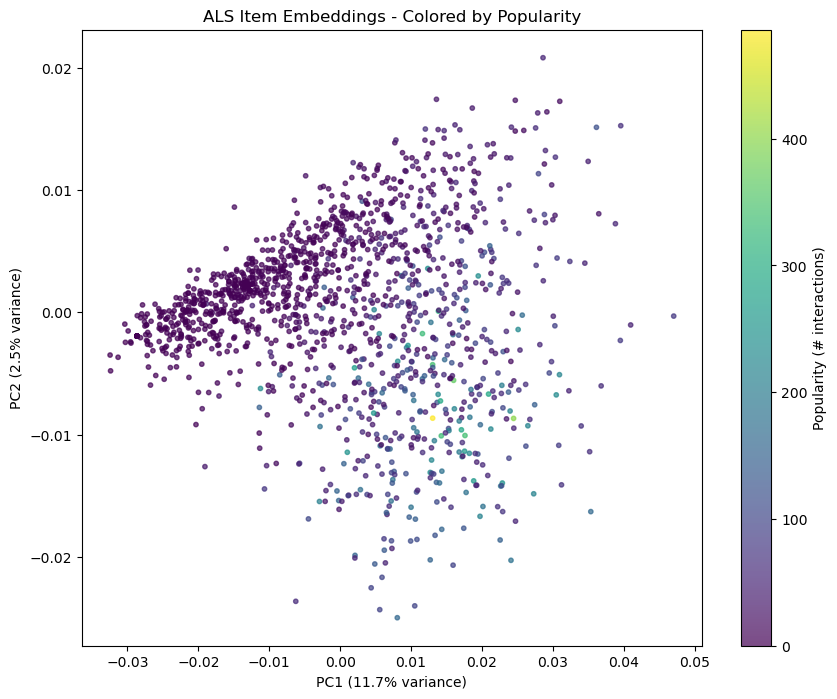

In [384]:

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get item factors from ALS model
item_factors = best_als.model.item_factors  # shape: (n_items, factors)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(item_factors)

# ============================================================
# Color by Item Popularity
# ============================================================

# Calculate item popularity (number of interactions)
item_popularity = np.array(R_train.sum(axis=0)).flatten()

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    s=10,
    c=item_popularity,
    cmap='viridis',
    alpha=0.7
)
plt.colorbar(scatter, label='Popularity (# interactions)')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)")
plt.title("ALS Item Embeddings - Colored by Popularity")
plt.show()


- Scattered popular items → Model learns personalized patterns ✓
    - If popular items clustered → Model just learns "recommend popular"

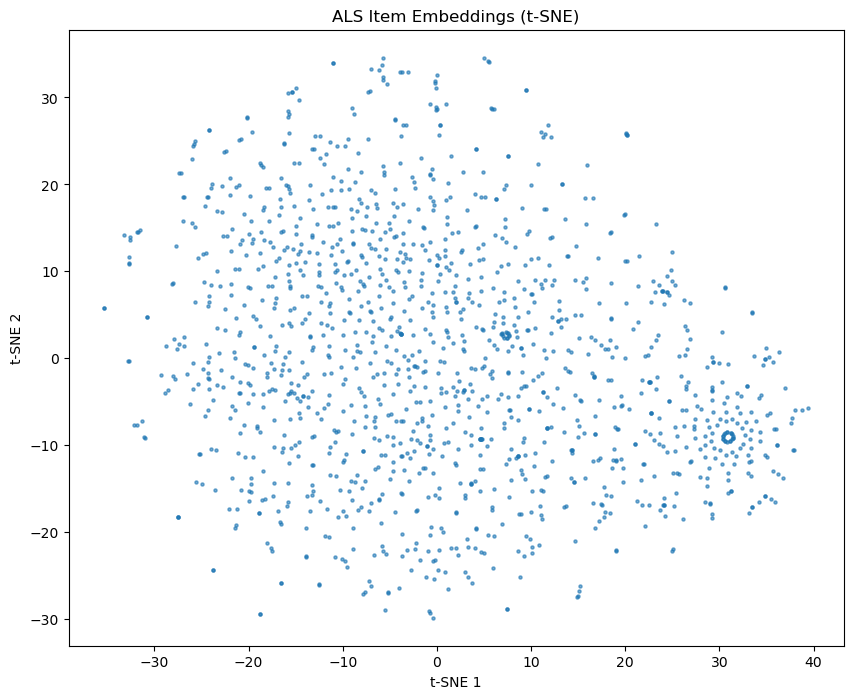

In [385]:
# ============================================================
# t-SNE for Better Cluster Visualization
# ============================================================

from sklearn.manifold import TSNE

# t-SNE (slower but often better clustering)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(best_als.model.item_factors)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=5, alpha=0.6)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.title("ALS Item Embeddings (t-SNE)")
plt.show()


- The **embeddings are working** (items spread out, not collapsed), but the lack of clusters suggests ALS is learning fine-grained collaborative signals rather than broad item categories. This is normal for matrix factorization on MovieLens.

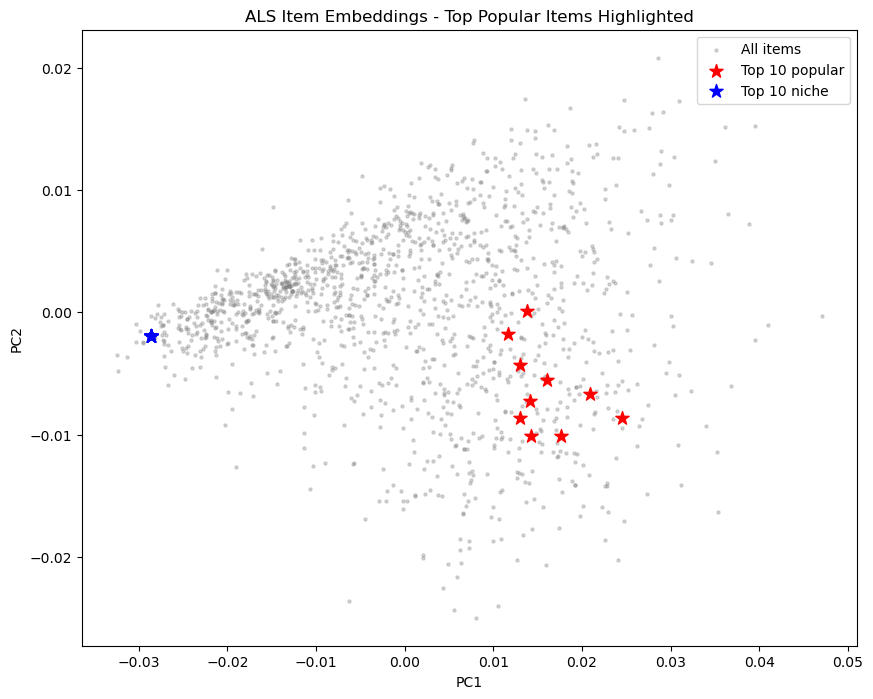

In [392]:
# ============================================================
# Highlight Top-10 Popular Items
# ============================================================

top_k = 10
top_items = np.argsort(item_popularity)[::-1][:top_k]
# Highlight LEAST popular items
bottom_items = np.argsort(item_popularity)[:10]
# Are they on the left side? (opposite of popular)

plt.figure(figsize=(10, 8))

# All items (gray)
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.3, c='gray', label='All items')

# Top popular items (red)
plt.scatter(
    X_pca[top_items, 0], 
    X_pca[top_items, 1], 
    s=100, 
    c='red', 
    marker='*',
    label=f'Top {top_k} popular'
)

# Niche items (blue)
plt.scatter(
    X_pca[bottom_items, 0], 
    X_pca[bottom_items, 1], 
    s=100, 
    c='blue', 
    marker='*',
    label=f'Top {top_k} niche'
)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("ALS Item Embeddings - Top Popular Items Highlighted")
plt.legend()
plt.show()


In [ ]:
# Correlation between PC1 and popularity
correlation = np.corrcoef(X_pca[:, 0], item_popularity)[0, 1]
print(f"PC1-Popularity correlation: {correlation:.3f}")

# If correlation > 0.5 → PC1 strongly captures popularity

PC1-Popularity correlation: 0.503


In [394]:
# ============================================================
# Detailed Personalization Check
# ============================================================

# Find users with different tastes
user_profiles = {}
for uid in range(min(200, n_users)):
    user_items = R_train[uid].indices
    if len(user_items) > 0:
        avg_pop = item_popularity[user_items].mean()
        user_profiles[uid] = avg_pop

# Find a "mainstream" user and a "niche" user
sorted_users = sorted(user_profiles.items(), key=lambda x: x[1])
niche_user = sorted_users[10][0]      # Low avg popularity
mainstream_user = sorted_users[-10][0] # High avg popularity

print(f"Niche user {niche_user}: avg item popularity = {user_profiles[niche_user]:.1f}")
print(f"Mainstream user {mainstream_user}: avg item popularity = {user_profiles[mainstream_user]:.1f}")
print()

# Get recommendations
recs_niche = best_als.recommend(niche_user, K=10)
recs_mainstream = best_als.recommend(mainstream_user, K=10)

print("Niche user recommendations:")
print(f"  Items: {recs_niche}")
print(f"  Avg popularity: {item_popularity[recs_niche].mean():.1f}")

print("\nMainstream user recommendations:")
print(f"  Items: {recs_mainstream}")
print(f"  Avg popularity: {item_popularity[recs_mainstream].mean():.1f}")

print(f"\nOverlap: {len(set(recs_niche) & set(recs_mainstream))} / 10")

# Verdict
overlap = len(set(recs_niche) & set(recs_mainstream))
if overlap <= 2:
    print("\n✓ Good personalization - different users get different recs")
elif overlap <= 5:
    print("\n~ Moderate personalization - some overlap")
else:
    print("\n✗ High overlap - potential popularity bias")


Niche user 68: avg item popularity = 87.6
Mainstream user 113: avg item popularity = 176.1

Niche user recommendations:
  Items: [501  91 283 340 610 246 192 301 454  64]
  Avg popularity: 142.3

Mainstream user recommendations:
  Items: [208 661  95 202  32  28 204  82 145 459]
  Avg popularity: 206.3

Overlap: 0 / 10

✓ Good personalization - different users get different recs
